In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.notebook_utils import fetchIndicators, genDataForAll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

/mnt/c/Users/jam60/OneDrive/Repos/vivaldi/back_testing


In [2]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

model = Trading(load_config())
dataset = model.dfs[0][0]

In [3]:
my_inds = fetchIndicators(["rsi", "macd", "stochastic_oscillator", "optimal_v2"])
genDataForAll(dataset, my_inds)
dataset.dropna(inplace=True)

In [4]:
mm_scalar = MinMaxScaler()
dataset[["rsi", "stosc_k", "stosc_d"]] = mm_scalar.fit_transform(dataset[["rsi", "stosc_k", "stosc_d"]])

def filter_optimal(optimal):
    if optimal > 0.9:
        return 1.0
    elif optimal < -0.9:
        return -1.0
    else:
        return 0.0

dataset['optimal'] = dataset.apply(lambda x: filter_optimal(x.optimal), axis=1)

In [24]:
filtered_dataset = dataset[["close", "rsi", "MACD", "stosc_k", "stosc_d"]]

is_optimal = dataset[['optimal']]

raw_x_train_df, raw_x_test_df, raw_y_train_df, raw_y_test_df = train_test_split(filtered_dataset, is_optimal, test_size=0.2, shuffle=False)

classify_all = np.array(dataset)
optimal_all = np.array(is_optimal)
classify_X_train = np.array(raw_x_train_df)
classify_X_test = np.array(raw_x_test_df)
classify_y_train = np.array(raw_y_train_df)
classify_y_test = np.array(raw_y_test_df)

<h3>Models</h3>
<p>Random Forest</p>
<p>Fine tuned RF</p>
<p>Gradient boost</p>
<p>GB inside RF</p>
<p>RF inside GB</p>
<p>LSTM</p>

In [10]:
clf = RandomForestClassifier(random_state=69420, n_jobs=-1)
clf.fit(classify_X_train, classify_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=69420,
                       verbose=0, warm_start=False)

In [8]:
clf.score(classify_X_test, classify_y_test)

0.9805414503418952

In [18]:
def insert_buys(close, prediction):
    if prediction == 1:# and heat_val > 0.6:
        return close
    else:
        return None

def insert_sells(close, prediction):
    if prediction == -1:
        return close
    else:
        return None

In [25]:

raw_x_test_df['predict'] = clf.predict(raw_x_test_df.values)

In [28]:
len(raw_x_test_df[raw_x_test_df['predict'] != 0.0])

38

In [29]:
len(raw_x_test_df)

702262

In [19]:
raw_x_test_df['buy'] = raw_x_test_df.apply(lambda x: insert_buys(x.close, x.predict), axis=1)
raw_x_test_df['sell'] = raw_x_test_df.apply(lambda x: insert_sells(x.close, x.predict), axis=1)

In [21]:
raw_x_test_df = raw_x_test_df.head(10080)

<Figure size 432x288 with 0 Axes>

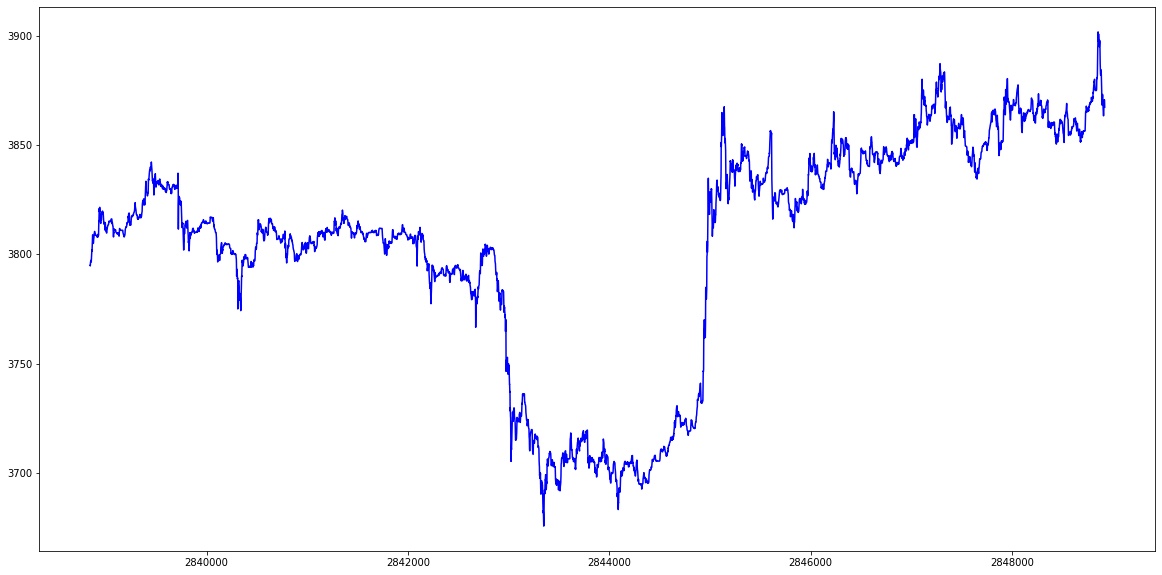

In [22]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(x=raw_x_test_df.index, y=raw_x_test_df['buy'], color='green')
plt.scatter(x=raw_x_test_df.index, y=raw_x_test_df['sell'], color='red')

plt.plot(raw_x_test_df.index, classify_X_test[:,0][:10080], color='blue')
plt.show()